In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *

from encoding_information.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2023-10-25 08:50:41.559996: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 08:50:42.881802: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM


In [ ]:
edge_crop = 32
patch_size = 10

num_images = 5000
num_patches = 5000

channel = 'LED119'
confidence_interval = 90
num_bootstrap_samples = 50

images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)


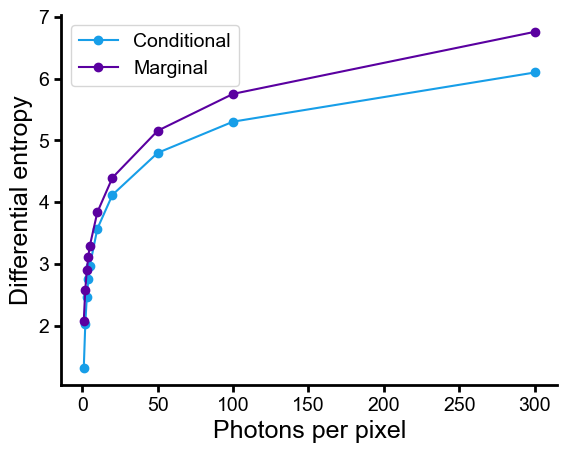

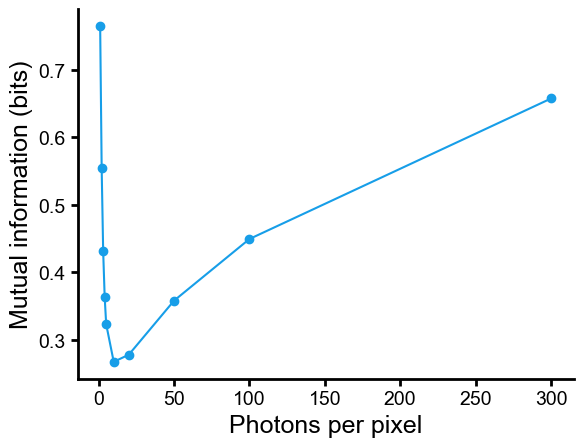

In [6]:
# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 2, 3, 4, 5, 10, 20, 50, 100, 300]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]

conditionals = []
marginals = []
mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    noisy_patches + onp.random.normal(size=noisy_patches.shape) 
    # mi.append(estimate_mutual_information(noisy_images=noisy_patches, verbose=True))
    h_y_given_x = estimate_conditional_entropy(noisy_patches) / np.log(2)
    h_y_gaussian = est(noisy_patches, stationary=True, eigenvalue_floor=1, show_plot=False) / np.log(2)
    conditionals.append(h_y_given_x)
    marginals.append(h_y_gaussian)
    mi.append(h_y_gaussian - h_y_given_x)

# plot both
fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, conditionals, '-o', label='Conditional')
ax.plot(photons_per_pixel_values, marginals, '-o', label='Marginal')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Differential entropy')
ax.legend()
clear_spines(ax)

fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, mi, '-o')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Mutual information (bits)')
clear_spines(ax)

## Does using the non-stationary gaussian model rescue it? No

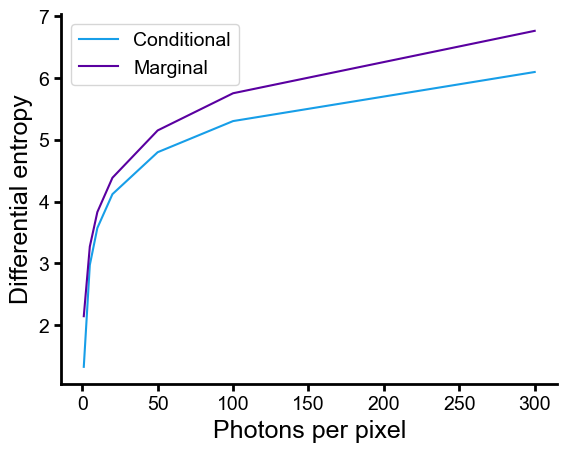

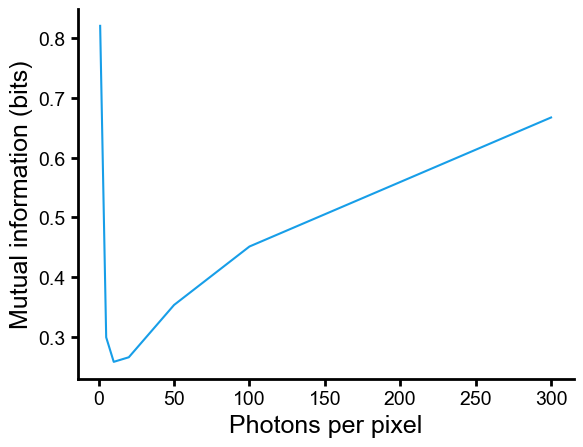

In [25]:
# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 5, 10, 20, 50, 100, 300]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]

conditionals = []
marginals = []
mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    noisy_patches + onp.random.normal(size=noisy_patches.shape) 
    # mi.append(estimate_mutual_information(noisy_images=noisy_patches, verbose=True))
    h_y_given_x = compute_conditional_entropy(noisy_patches) / np.log(2)
    h_y_gaussian = gaussian_entropy_estimate(noisy_patches, stationary=False, eigenvalue_floor=1) / np.log(2)
    conditionals.append(h_y_given_x)
    marginals.append(h_y_gaussian)
    mi.append(h_y_gaussian - h_y_given_x)

# plot both
fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, conditionals, label='Conditional')
ax.plot(photons_per_pixel_values, marginals, label='Marginal')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Differential entropy')
ax.legend()
clear_spines(ax)

fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, mi)
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Mutual information (bits)')
clear_spines(ax)

## Does generating the conditional entropy estimate from samples from the gaussian fit rescue it?
run the first two notebooks cells to prep for this

Text(0.5, 0.98, 'MI with conditional entropy estimated from model samples')

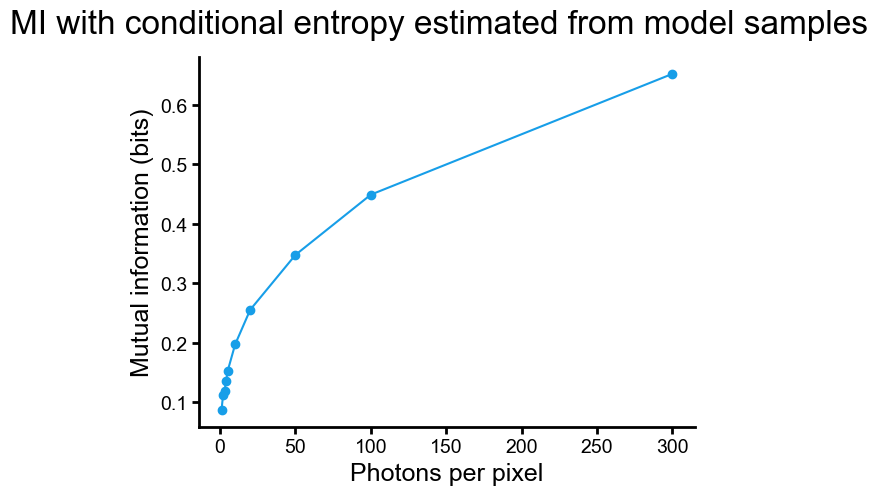

In [28]:
from information_estimation import *

# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 2, 3, 4, 5, 10, 20, 50, 100, 300]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]


mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    noisy_patches + onp.random.normal(size=noisy_patches.shape) 
    lower_photon_clean_images = patches * photons_per_pixel / np.mean(images)
    mi.append(estimate_mutual_information(noisy_images=noisy_patches, eigenvalue_floor=1e-3,
                                          clean_images=lower_photon_clean_images, estimate_conditional_from_model_samples=True,
                                          poisson_approx_threshold=0,
                                verbose=False))


fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, mi, '-o')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Mutual information (bits)')
clear_spines(ax)
fig.suptitle('MI with conditional entropy estimated from model samples')

## Does adding iterative estimation help?

/home/hpinkard_waller/GitRepos/EncodingInformation/gaussian_process_utils.py:518: UserWarning: Optimization did not improve the validation loss, returning initial covariance matrix
  if verbose:


Text(0.5, 0.98, 'MI with conditional entropy estimated from model samples')

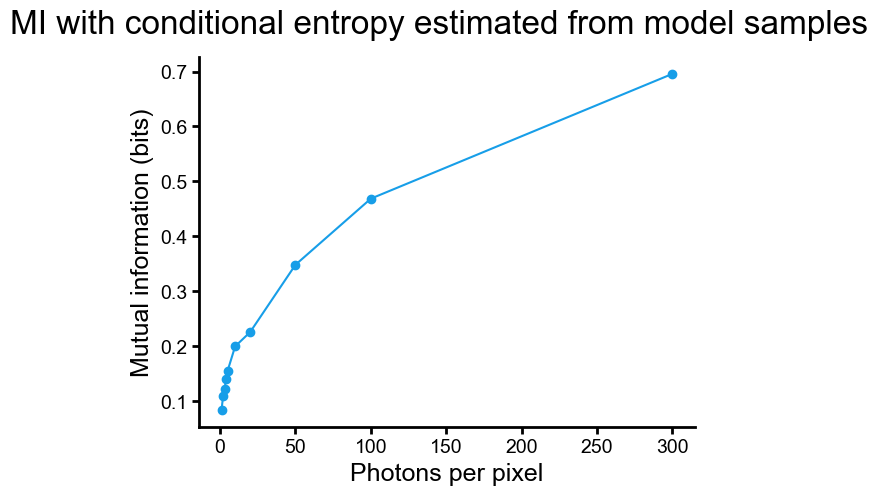

In [29]:
edge_crop = 32
patch_size = 10

num_images = 5000
num_patches = 5000

channel = 'LED119'
confidence_interval = 90
num_bootstrap_samples = 50

images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)



# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 2, 3, 4, 5, 10, 20, 50, 100, 300]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]


mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    noisy_patches + onp.random.normal(size=noisy_patches.shape) 
    lower_photon_clean_images = patches * photons_per_pixel / np.mean(images)
    mi.append(estimate_mutual_information(noisy_images=noisy_patches, eigenvalue_floor=1e-3, use_iterative_optimization=True,
                                          clean_images=lower_photon_clean_images, estimate_conditional_from_model_samples=True,
                                        #   learning_rate=1e-10, 
                                        #   batch_size=40,
                                verbose=False))


fig, ax = plt.subplots()
ax.plot(photons_per_pixel_values, mi, '-o')
ax.set_xlabel('Photons per pixel')
ax.set_ylabel('Mutual information (bits)')
clear_spines(ax)
fig.suptitle('MI with conditional entropy estimated from model samples')